In [1]:
from fastai.vision.all import *

In [2]:
# Load dataset
path = untar_data(URLs.PETS)

In [3]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('annotations'),Path('images')]

In [4]:
(path/"images").ls()

(#7393) [Path('images/Abyssinian_1.jpg'),Path('images/Abyssinian_10.jpg'),Path('images/Abyssinian_100.jpg'),Path('images/Abyssinian_100.mat'),Path('images/Abyssinian_101.jpg'),Path('images/Abyssinian_101.mat'),Path('images/Abyssinian_102.jpg'),Path('images/Abyssinian_102.mat'),Path('images/Abyssinian_103.jpg'),Path('images/Abyssinian_104.jpg'),Path('images/Abyssinian_105.jpg'),Path('images/Abyssinian_106.jpg'),Path('images/Abyssinian_107.jpg'),Path('images/Abyssinian_108.jpg'),Path('images/Abyssinian_109.jpg'),Path('images/Abyssinian_11.jpg'),Path('images/Abyssinian_110.jpg'),Path('images/Abyssinian_111.jpg'),Path('images/Abyssinian_112.jpg'),Path('images/Abyssinian_113.jpg')...]

In [5]:
fname = (path/"images").ls()[0]

In [6]:
# Extract pet breed using regx
re.findall(r'(.+)_\d+.jpg',fname.name)

['Abyssinian']

In [7]:
# Apply regex and create our dataset
pets = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                 get_items = get_image_files, splitter = RandomSplitter(seed = 42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms = aug_transforms(size = 224, min_scale = 0.75)
                )
dls = pets.dataloaders(path/"images")

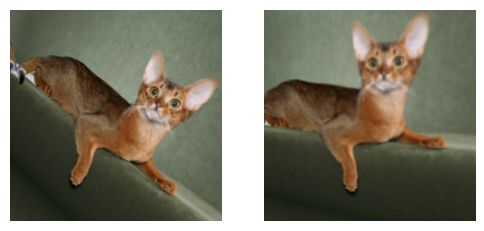

In [8]:
# View image transformation
dblock1 = DataBlock(blocks = (ImageBlock(), CategoryBlock()),
                    get_y = parent_label,
                    item_tfms=Resize(460)
                   )
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(path/'images'/'Abyssinian_1.jpg')]* 100, bs = 8)
dls1.train.get_idxs = lambda: Inf.ones
x, y = dls1.valid.one_batch()
_, axs = subplots(1,2)
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz = 224)
x1.rotate(draw = 30, p = 1)
x1 = x1.zoom(draw = 1.2, p =1.)
x1 = x1.warp(draw_x = -0.2, draw_y = 0.2, p = 1.)
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);
     

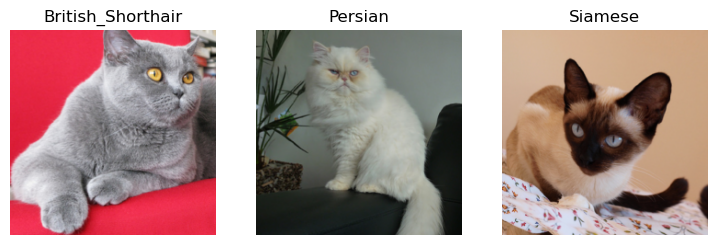

In [9]:
# Check dataset
dls.show_batch(nrows = 1, ncols = 3)

In [10]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\sande\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\sande\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na':

In [11]:
learn = vision_learner(dls, resnet34, metrics = error_rate )
learn.dls.to('cuda')  # Move dataloaders to GPU
learn.model.to('cuda')  # Move model to GPU
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.520254,0.335575,0.110284,01:46


epoch,train_loss,valid_loss,error_rate,time
0,0.501730,0.292776,0.108254,01:55
1,0.318920,0.205946,0.068336,01:55


As we've briefly discussed before, the table shown when we fit a model shows us the results after each epoch of training. Remember, an epoch is one complete pass through all of the images in the data. The columns shown are the average loss over the items of the training set, the loss on the validation set, and any metrics that we requested—in this case, the error rate.

Remember that loss is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using cross-entropy loss.

In [12]:
import torch
print("GPU Available:", torch.cuda.is_available())  # Should return True
print("GPU Count:", torch.cuda.device_count())  # Number of GPUs available
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))  # Name of the GPU
    print("CUDA Version:", torch.version.cuda)  # CUDA version

GPU Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce GTX 1650
CUDA Version: 11.8


In [13]:
torch.cuda.empty_cache()

# Understanding cross entropy loss

Cross-entropy loss is a loss function that is similar to the one we used in the previous chapter, but (as we'll see) has two benefits:

It works even when our dependent variable has more than two categories.
It results in faster and more reliable training.
In order to understand how cross-entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations that are seen by the loss function look like.

# Viewing activations and labels

Let's look at our models activation function:

In [14]:
x, y = dls.one_batch()

In [15]:
y

TensorCategory([11,  5, 14, 26, 12,  7, 25, 23, 29, 28, 17, 12, 35,  3, 18, 20,
                34, 35, 29, 31, 16, 26,  8, 14,  3,  7, 25, 18,  7, 25, 25, 34,
                 4, 15, 24,  3, 22,  4, 28,  7, 23, 30,  9, 20,  8, 21,  9, 24,
                35, 22, 28, 10, 31, 11,  9, 18, 35, 29,  9,  6, 32, 13, 20, 31],
               device='cuda:0')

In [16]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.2419e-04, 1.0149e-05, 7.5915e-08, 6.2666e-07, 7.9600e-07, 6.5090e-05,
        1.1530e-07, 1.0898e-07, 1.7238e-08, 2.0869e-06, 2.5414e-07, 9.9976e-01,
        7.4146e-07, 4.7990e-07, 6.5446e-06, 3.6177e-07, 3.6508e-08, 3.1827e-07,
        3.0020e-07, 3.9710e-06, 2.6391e-05, 1.3764e-08, 3.9519e-08, 1.0342e-08,
        3.8928e-09, 6.9397e-09, 9.0943e-07, 7.7324e-08, 6.9935e-09, 1.8282e-09,
        1.2583e-08, 1.7295e-08, 6.1630e-07, 1.4180e-07, 2.1691e-08, 4.3407e-08,
        7.0060e-08])

In [17]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

To transform this into 0 or 1 to get clear preds we use the softmax activation function

In [18]:
torch.random.manual_seed(42);

In [19]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [20]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [21]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [22]:
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [23]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts 

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Softmax is the multi-category equivalent of sigmoid, Basically softmax can give probablites sumemd upto 1. Since we have 37 categories we have 37 values which just sum up to 1 and we pick the highest one as our pred. Whereas sigmoid can give preds and we pick the highest one.

## We also need to extend loss function for multi class classification, we will use log likelihood. 

In [24]:
# Example
targ = tensor([0,1,0,1,1,0])

In [25]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [26]:
idx = range(6)
idx


range(0, 6)

In [27]:
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [36]:
from IPython.display import HTML

df = pd.DataFrame(sm_acts, columns=["3", "7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
df["loss"] = -torch.log(tensor(df['result']))
# Hide the index
t = df.style.hide(axis="index")

# Render styled DataFrame as HTML
html = t._repr_html_()

# No need to split or use re.sub unless you’re modifying content
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


In [29]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [30]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Negative Log Likelihood:

Taking the negative log of the probability which is also called cross-entropy loss. In pytorch it is available as `nn.CrossEntropyLoss` which does `log softmax` and then `nll_loss`

In [31]:
loss_func = nn.CrossEntropyLoss()

In [33]:
loss_func(acts, targ)

tensor(1.8045)

By default PyTorch loss functions take the mean of the loss of all items. You can use reduction='none' to disable that:

In [34]:
nn.CrossEntropyLoss(reduction = 'none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

You will notice these values match the `loss` column in our table exactly.

# Model Interpretation:

Let's plot a `ConfusionMatrix`

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

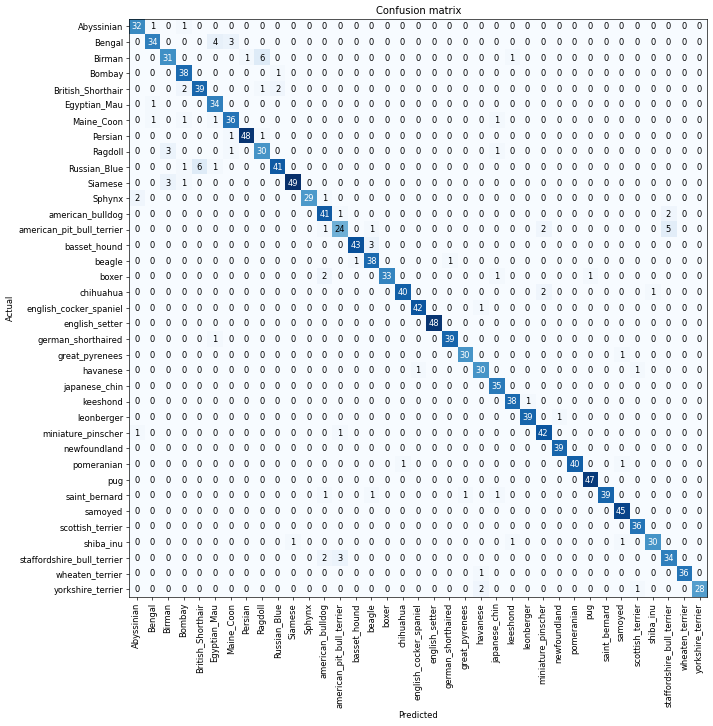

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [40]:
# Get most confused predictions
interp.most_confused(min_val = 5)

[('Birman', 'Ragdoll', 6),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]

# Improving model

### The Learning Rate Finder


In [41]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1, base_lr = 0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.561108,6.593807,0.513532,01:43


epoch,train_loss,valid_loss,error_rate,time
0,3.792838,2.075742,0.600812,01:55


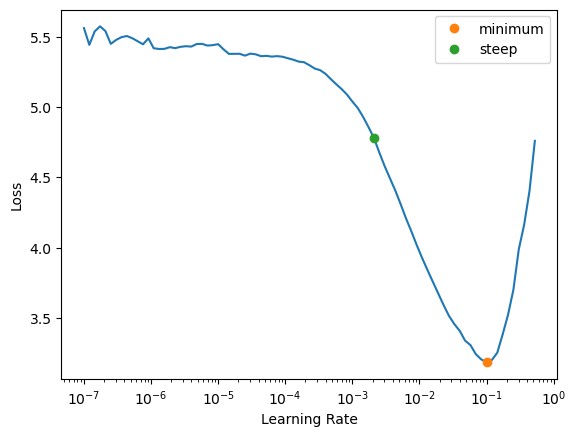

In [42]:
# Implement Learning Rate Finder
learn  = vision_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs = (minimum, steep))

In [43]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 2.09e-03


In [44]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.316796,0.343255,0.108254,01:42


epoch,train_loss,valid_loss,error_rate,time
0,0.554761,0.364584,0.116373,01:54
1,0.304099,0.220830,0.070365,01:54


In [45]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      c:\learning-progress\env\lib\site-packages\fastai\callback\schedule.py
Type:      method

In [46]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.133601,0.292691,0.095399,01:41
1,0.549521,0.235864,0.080514,01:41
2,0.332346,0.204404,0.065629,01:41


In [47]:
learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

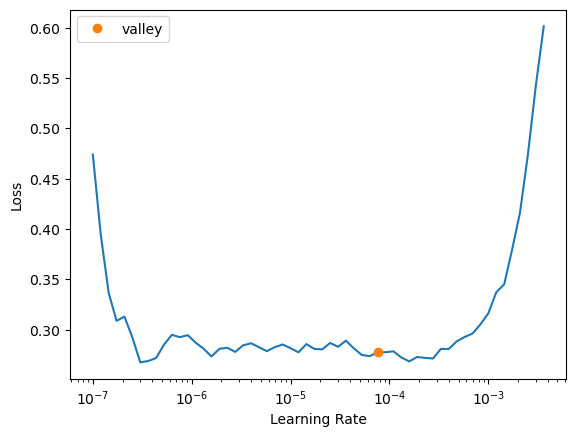

In [48]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.268862,0.199798,0.062923,01:53
1,0.238194,0.188446,0.060217,01:56
2,0.221274,0.177806,0.056834,01:57
3,0.198636,0.177827,0.055480,01:54
4,0.191373,0.172620,0.050744,01:56
5,0.186491,0.172179,0.053451,01:54


### Discriminative Learning Rates

In [50]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.128483,0.316721,0.098782,01:42
1,0.537607,0.242708,0.075778,01:42
2,0.332551,0.222951,0.073748,01:41


epoch,train_loss,valid_loss,error_rate,time
0,0.270497,0.215306,0.072395,02:29
1,0.262680,0.210619,0.064953,02:29
2,0.248983,0.201759,0.064276,02:32
3,0.227317,0.201565,0.066306,02:28
4,0.198331,0.196800,0.056157,02:29
5,0.168334,0.194826,0.059540,02:29
6,0.168620,0.195211,0.058187,02:29
7,0.149239,0.191414,0.062923,02:31
8,0.140064,0.192235,0.059540,02:30
9,0.133592,0.189352,0.060893,02:30
